In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

### Functions for parsing, processing, and plotting data

In [3]:
def extract_game_numbers_data(path_to_dir, time, dimension, game_numbers):
    data = {}
    for i in game_numbers:
        with open(f'{path_to_dir}/{time}_{dimension}_{i}.json') as json_file:
            data[i] = json.load(json_file)       
    return data

def extract_dimensions_data(path_to_dir, time, dimensions, game_numbers):
    data = {}
    for i in dimensions:
        data[i] = extract_game_numbers_data(path_to_dir, time, i, game_numbers)
    return data

def extract_times_data(path_to_dir, times, dimensions, game_numbers):
    data = {}
    for i in times:
        data[i] = extract_dimensions_data(path_to_dir, i, dimensions, game_numbers)
    return data

# Used to extract the full data tree for an entire directory of simulations. Indexed by the 
# time of the longer player, the dimension, then the game number. 
def read_games_from_json(path_to_dir, times, dimensions, game_numbers):
    data = extract_times_data(path_to_dir, times, dimensions, game_numbers)
    return data

In [4]:
def get_win_rate(data, time, dimension):
    long_wins = 0
    short_wins = 0
    
    if dimension == 'total':
        for d in data.keys():
            long, short = get_win_rate(data, time, d)
            long_wins += long
            short_wins += short
        return long_wins, short_wins
    
    else: 
        data = data[dimension]
        for game in data.values():
            if game['winner'] == time:
                long_wins += 1
            elif game['winner'] != 0:
                short_wins += 1
        return long_wins, short_wins
    
def div_tuple(pair):
    if pair == (0, 0): return 0.5
    elif pair[1] == 0: return 1
    else: return pair[0] / pair[1]

# Plots win rate vs time given a full data tree of 2xSimulations. win rate is the number of times the longer player won
# over the number of times the shorter player won. Data is plotted for each dimension and aggregate. 
def plot_win_rate_vs_time(data):
    times = [time for time in data.keys()]
    time_buckets = [i for i in range(len(times))]
    dimensions = [d for d in data[times[0]].keys()]
    win_rates = []
    
    for dimension in dimensions:
        win_rates.append([div_tuple(get_win_rate(data[time], time, dimension)) for time in times])
    win_rates.append([div_tuple(get_win_rate(data[time], time, 'total')) for time in times])
    
    # Each row of win_rates corresponds to a fixed dimension. Each column is a fixed time. The last row
    # is an aggregate over all dimensions
    
    win_rates = np.array(win_rates)
    time_buckets = np.array(time_buckets)
    
    fig, ax = plt.subplots()
    for i in range(len(dimensions)):
        ax.plot(time_buckets, win_rates[i], label=f'dim {dimensions[i]}')
    ax.plot(time_buckets, win_rates[-1], label=f'aggregate')
    ax.set_xlabel('Time Magnitude')
    ax.set_ylabel('Win Rate')
    ax.set_title('Win Rate vs Time Magnitutde')
    ax.legend()
                     
    

In [5]:
# Plots the number of simulations vs move_num. Called on the data for a single game. Requires the AI's playing to use
# the same time
def plot_simulation_progression(game_data, title):
    assert game_data['p1'] == game_data['p2']
    time = game_data['p1']
    moves = game_data['moves']
    move_num = [i for i in range(1, len(moves) + 1)]
    sim_counts = []
    for i in range(len(moves)):
        sim_counts.append(moves[i]['simulations'])
    
    move_num = np.array(move_num)
    sim_counts = np.array(sim_counts)
    
    fig, ax = plt.subplots()
    ax.plot(move_num, sim_counts, label=f'{time} seconds')
    ax.set_xlabel('Move Number')
    ax.set_ylabel('Number of Simulations')
    ax.set_title(title)
    ax.legend()

In [6]:
# Plots number of simulations in the first move vs dimension given data that starts at a dimension index
def plot_simulation_vs_dimension(data, title):
    dimensions = [d for d in data.keys()]
    time = data[dimensions[0]][0]['p1']
    first_move_sim_counts = []
    for d in dimensions:
        game = data[d][0]
        first_move = game['moves'][0]
        first_move_sim_counts.append(first_move['simulations'])
    
    dimensions = np.array(dimensions)
    first_move_sim_counts = np.array(first_move_sim_counts)
    
    fig, ax = plt.subplots()
    ax.plot(dimensions, sim_counts, label=f'{time} seconds')
    ax.set_xlabel('Dimension')
    ax.set_ylabel('Number of Simulations')
    ax.set_title(title)
    ax.legend()
        

In [7]:
# Plots a scatter plot of best move_score vs move_num and plots points of different colors for different dimensions. 
# Takes in data at the dimension level of indexing
def plot_move_certainty_vs_move_num(data):
    dimensions = [d for d in data.keys()]
    move_num = []
    score = []
    color = [i for i in range(1, len(dimensions) + 1)]
    for d in dimensions:
        score_d = []
        move_num_d = []
        for game in data[d]:
            moves = game['moves']
            for i in range(len(moves)):
                score_d.append(moves[i]['stats'][0]['pts']/moves[i]['stats'][0]['attempts'])
                move_num_d.append(i)
        move_num.append(move_num_d)
        score.append(score_d)
    
    move_num = np.array(move_num)
    score = np.array(score)
    color = np.array(color).reshape(len(dimensions), 1)
    
    fig, ax = plt.subplots()
    for i in range(len(dimensions)):
        ax.scatter(move_num[i], score[i], c=color[i][0], label=f'dim {dimensions[i]}')
    ax.set_xlabel('Move Num')
    ax.set_ylabel('Move Score')
    ax.set_title('Move Score Progression in Different Dimensions')
    ax.legend()

### Experiment 1: Win Rate vs Time Magnitude Over Different Dimensions

In [9]:
# Joining data in 2xSimulations into a single Dictionary
times = [2 ** i for i in range(5)]
dimensions = [i for i in range(4, 9)]
game_numbers = [i for i in range(10)]
data = read_games_from_json('./2xSimulations', times, dimensions, game_numbers)

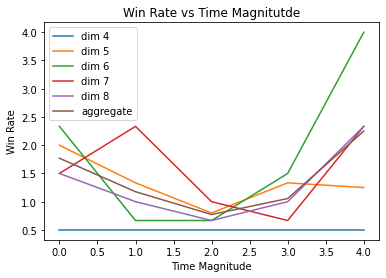

In [10]:
plot_win_rate_vs_time(data)